In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import pingouin as pg
import statsmodels.api as sm
# import language_tool_python as ltp
import sys
sys.path.append('..')  
# from src.visualization.plot import raincloud, raincloud2, RainCloud
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

    

In [2]:
df = pd.read_csv('../data/processed/restored_dv2_dv3_dv2h_cleaned.csv')

# just print some descriptive info
for engine in df.engine.unique():
    print('Experiment=', end=' ')
    print(engine)
    print('-'*15)
    print('Size=', end=' ')
    print(df[df.engine==engine].shape)
    # print n subject
    print('N datasets =', end=' ')
    # group by engine and prolific_id, then count unique dataset_id
    dd = df[df.engine==engine].groupby(['prolific_id']).dataset_id.unique()
    n = sorted([i[0] for i in dd.values])
    print(len(n))
    print('N participants =', end=' ')
    print(df[df.engine==engine].dataset_id.nunique())

    # check if n unique dataset_id == n unique prolific_id
    if len(n) != df[df.engine==engine].dataset_id.nunique():
        print('WARNING: n unique dataset_id != n unique prolific_id')
        # show which dataset_id is doubled
        print('Doubled dataset_id=', end=' ')
        print([i for i in n if n.count(i) > 1])

    print('N trials = ', end='')
    # print n trials per subject
    print(df[df.engine==engine].prolific_id.value_counts().unique()[0])
    print()

df.loc[(((df.a0=='yes') & (df.agree1==1)) | ((df.a0=='no') & (df.agree1==0))), 'endorse'] = 1
df.loc[(((df.a0=='yes') & (df.agree1==0)) | ((df.a0=='no') & (df.agree1==1))), 'endorse'] = 0
df['endorse'] = df.endorse.astype(int)

Experiment= dv2
---------------
Size= (3542, 29)
N datasets = 77
N participants = 77
N trials = 46

Experiment= dv3
---------------
Size= (3420, 29)
N datasets = 76
N participants = 76
N trials = 45

Experiment= dv2_humanized
---------------
Size= (3542, 29)
N datasets = 77
N participants = 77
N trials = 46



In [3]:
avg_source = df.groupby(['engine', 'prolific_id', 'cond', 'source'], as_index=False).mean(numeric_only=True)
avg_answer = df.groupby(['engine', 'prolific_id', 'cond', 'answer'], as_index=False).mean(numeric_only=True)
# compute average p(correct)


count = 0
nan = 0
avg = None
bias = []

for id in avg_source.prolific_id.unique():
    for cond in avg_source.cond.unique():
        # get engine using id
        engine = avg_source[avg_source.prolific_id==id].engine.values[0]
        count += 1
        del avg
        avg = avg_source
        bias_source = avg[(avg.source=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]\
            - avg[(avg.source=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]
        # assert that there is only one value for each condition
        assert len(avg[(avg.source=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].agree) == 1
        assert len(avg[(avg.source=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].agree) == 1
        try: 
            del avg
            avg = avg_answer
            bias_answer = \
                avg[(avg.answer=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]\
                - avg[(avg.answer=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]
        except:
            nan += 1
            bias_answer = None 
            
        engine = avg_source[avg_source.prolific_id==id].engine.values[0]
        del avg
        avg = avg_source
        
        # do the same thing but with endorse instead of agree
        bias_source_endorse = avg[(avg.source=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].endorse.values[0]\
            - avg[(avg.source=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].endorse.values[0]
        # assert that there is only one value for each condition
        assert len(avg[(avg.source=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].endorse) == 1
        assert len(avg[(avg.source=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].endorse) == 1
        try: 
            del avg
            avg = avg_answer
            bias_answer_endorse = \
                avg[(avg.answer=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].endorse.values[0]\
                - avg[(avg.answer=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].endorse.values[0]
        except:
            nan += 1
            bias_answer_endorse = None
        
        bias.append(
            {
                'engine': engine,
                'prolific_id': id,
                'cond': cond,
                'bias_source': bias_source,
                'bias_answer': bias_answer,
                'bias_source_endorse': bias_source_endorse,
                'bias_answer_endorse': bias_answer_endorse
            }
        )

bias = pd.DataFrame(bias)


In [4]:
correct = df.groupby('prolific_id').correct.mean()
# Rename the column in the 'correct' DataFrame before merging
correct = correct.rename({'correct': 'correct_mean'})
# add correct column to bias
bias = bias.merge(correct, on='prolific_id')
bias

,engine,prolific_id,cond,bias_source,bias_answer,bias_source_endorse,bias_answer_endorse,correct
0,dv2,563f5535cbd4c60011dc9466,impersonal_moral,-0.354167,0.211111,0.083333,-0.022222,0.543478
1,dv2,563f5535cbd4c60011dc9466,non_moral,-0.085714,0.166667,-0.028571,0.166667,0.543478
2,dv2,563f5535cbd4c60011dc9466,personal_moral,0.000000,0.380952,0.266667,0.285714,0.543478
3,dv2,56bdf97bef423f000dcbb7eb,impersonal_moral,0.300000,0.333333,0.466667,0.095238,0.739130
4,dv2,56bdf97bef423f000dcbb7eb,non_moral,0.222222,0.583333,-0.222222,-0.166667,0.739130
...,...,...,...,...,...,...,...,...
685,dv3,63ea61d8106e3e2dc14c4cc7,non_moral,0.142857,0.200000,-0.047619,0.150000,0.866667
686,dv3,63ea61d8106e3e2dc14c4cc7,personal_moral,-0.312500,-0.277778,0.250000,0.222222,0.866667
687,dv3,63ea627512244090788d46ec,impersonal_moral,0.546154,0.666667,-0.261538,-0.333333,0.911111
688,dv3,63ea627512244090788d46ec,non_moral,0.000000,0.000000,-0.350000,0.454545,0.911111


In [5]:
def raincloud(x, y, markersize, df, order, width=1.1, bw=0.25, palette='Set2'):
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    means = df.groupby(x)[y].mean().reindex(order)
    sns.scatterplot(x=means.index, y=means, color='white', edgecolor='black', s=150/2, linewidth=1.5, zorder=4, clip_on=False)


    ax = pt.half_violinplot(x=x, y=y, data=df, bw=bw, cut=0., linewidth=0, alpha=1,  dodge=True,
                            scale="area", width=width, inner=None, orient='v', zorder=1, palette=palette, order=order)

    ax = sns.stripplot(x=x, y=y, data=df,edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, palette=palette, dodge=True, clip_on=False)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1, edgecolor='black', capsize=.1, zorder=3, bw=0, order=order, dodge=True)
    return ax

dataset= dv2
dataset= dv3


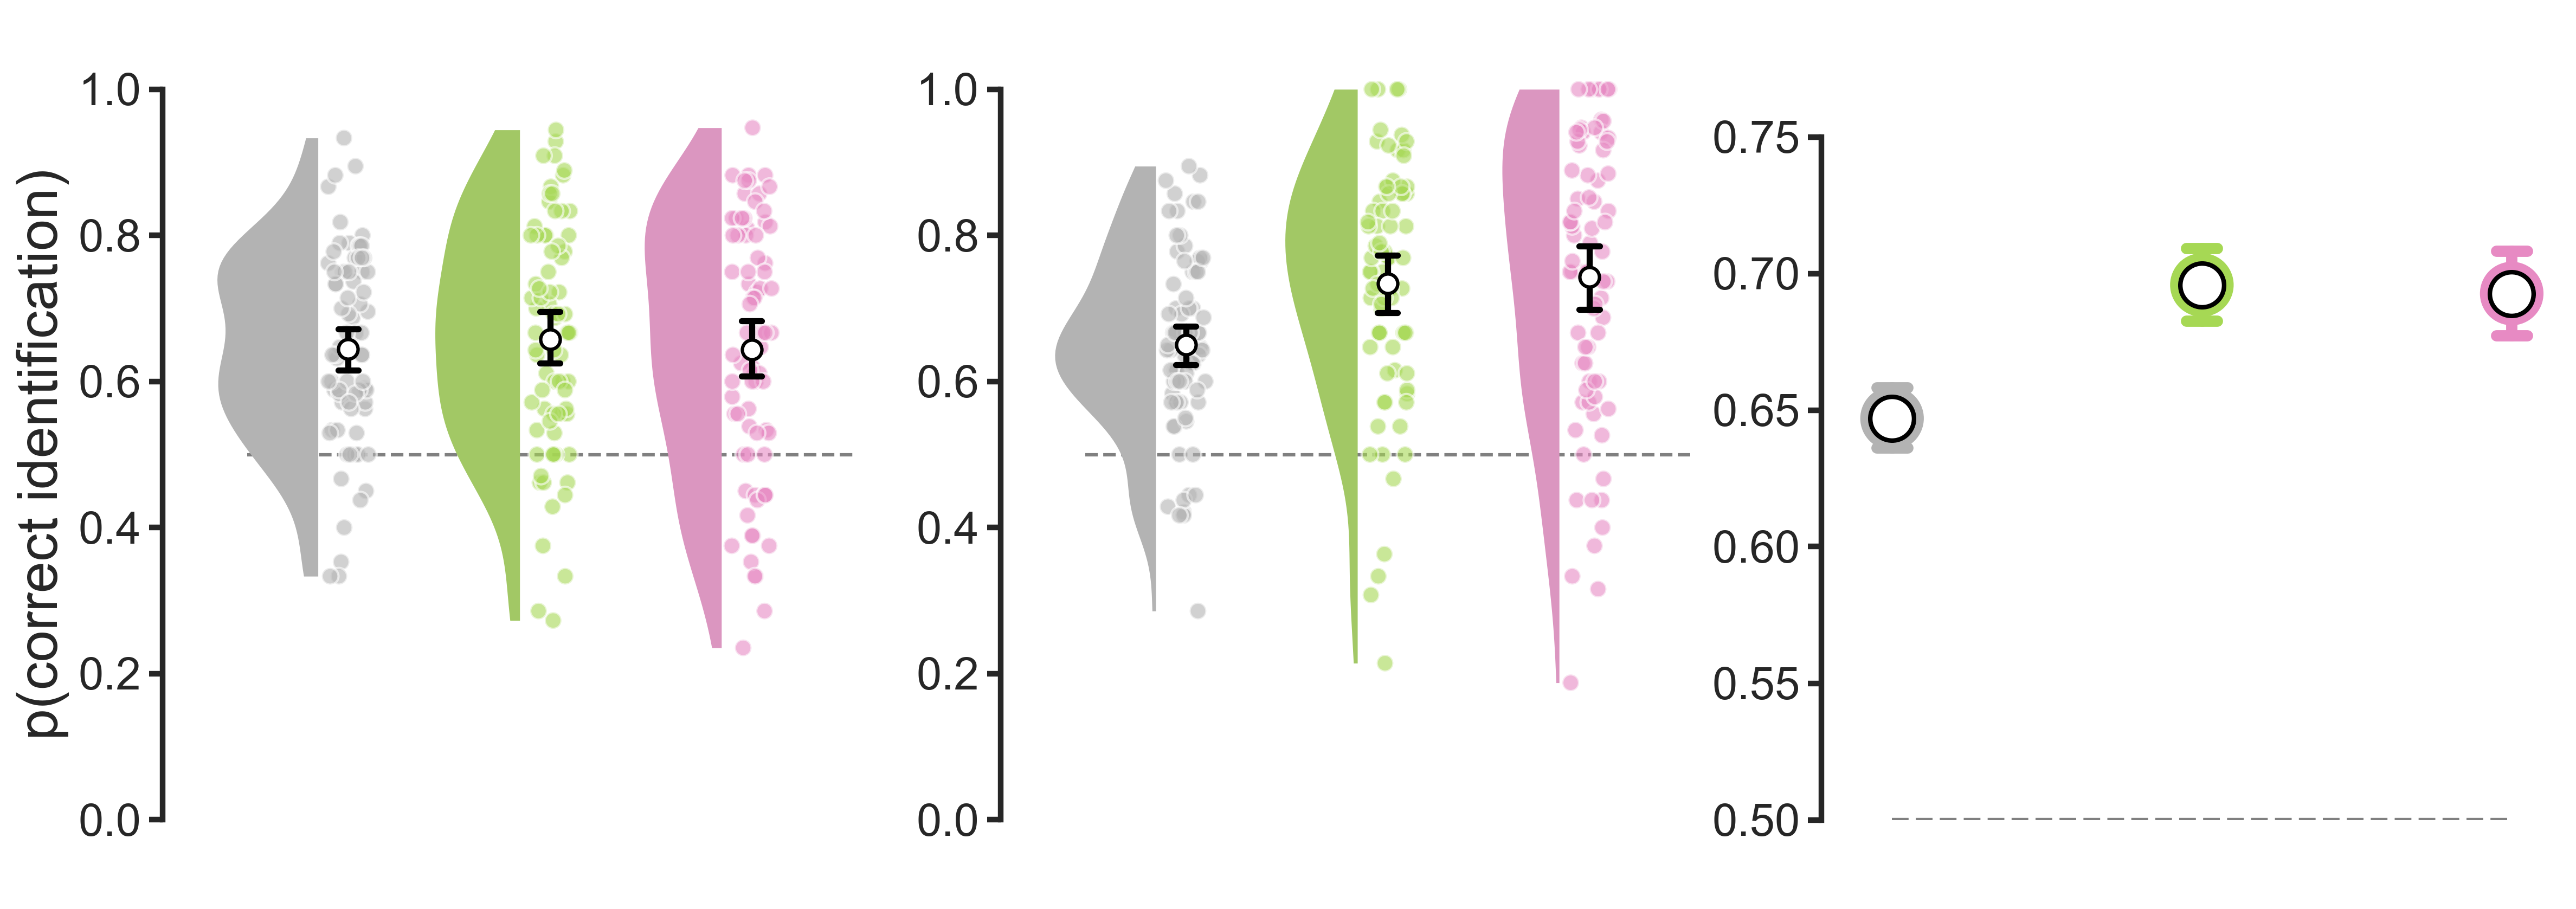

In [6]:
import matplotlib
font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)
# remove warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(
    rc={'figure.figsize':(16,6), "figure.dpi": 300, 'legend.fontsize': 20, 'axes.labelsize': 25,
      'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.family': 'sans-serif', 'axes.titlesize': 35,
      'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['axes.linewidth'] = 2.5


# remove warning 

palette = sns.color_palette("Set2")
p = [palette[7], palette[4], palette[3]]

green = '#71c055'
green2 = '#9bca3c'
mauve = '#d1499b'
mauve2 = '#854e9e'
palette = p#[palette[7], green2, mauve2]
sns.set_palette(p)

# avg = df.groupby(['engine', 'prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
order = ('non_moral', 'impersonal_moral', 'personal_moral')
y = 'correct'
count = 0
handles = []

for engine in ('dv2', 'dv3'):
    count += 1
    plt.subplot(1, 3, count)
    print('dataset=', engine)
    df_ = df[df.engine==engine].groupby(['prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
    # plt.plot([0, 2], [0, 0], 'k--', lw=2)
    
    # sns.barplot(x='cond', y=y, data=df_, order=order, zorder=-1)
    ax = raincloud(x='cond', y=y, markersize=7.4,   df=df_, order=order, palette=palette, width=1, bw=.4,)# lw=.5, lw2=.5)
    plt.ylabel(f'p(correct identification)')
    if count >1:
        plt.ylabel('')

    # plt.ylim(-1, 1)
    plt.ylim(-0.1, 1.1)
    # hline at 0
    x_lim = plt.gca().get_xlim()
    plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)

    # plt.axhline(0, color='k', ls='--', lw=1, zorder=-1, alpha=.5)
    plt.xlabel('')
    
    # rotate x-axis labels
    plt.xticks(rotation=45, labels=[], ticks=[])

    plt.tick_params(length=0, axis='x')

    # plt.yticks(np.arange(-1., 1.25, .25))
    # change yticks label fontsize
    plt.tick_params(axis='y', which='major', labelsize=20)

    # sns.stripplot(x='cond', y='bias_source', data=df_, edgecolor='w', linewidth=.8, jitter=0.1, size=7, order=order, zorder=1, alpha=.9)
    plt.tight_layout()
    # plt.title(engine.replace('_', ' '))
    
    sns.despine(bottom=True, offset=10, trim=True)

    # get handle for legend
    # h, labels  = ax.get_legend_handles_labels()
    # handles.append(h)
    
  # a legend horizontal line
# plt.legend(title='Condition', loc='upper center', bbox_to_anchor=(-0.7, -0.1), ncol=3, fontsize=20, title_fontsize=20)
# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# sns.barplot(x='cond', y=y, data=df_, order=order, zorder=-1)
plt.subplot(1, 3, 3)
avg_ = df.groupby(['engine', 'prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
# now average avg_ over engine = dv2, dv3
avg_ = avg_[avg_.engine.isin(['dv2', 'dv3'])].groupby(['prolific_id', 'cond'], as_index=False).mean(numeric_only=True)


plt.plot([0, 2], [0.5, 0.5], 'k--', lw=2, color='gray')
# ax = raincloud(x='engine', y=y, markersize=7.4,   df=avg_, order=('dv2', 'dv3', 'dv2_humanized'), palette=palette, width=1, bw=.3,)# lw=.5, lw2=.5)
y = 'correct'
# sns.barplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, errwidth=4, palette=palette, width=.7)
sns.pointplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, capsize=0.1, errwidth=5, palette=palette, scale=3.2, join=False)
plt.scatter(x=[0, 1, 2], y=avg_.groupby('cond').correct.mean().reindex(order), color='white', s=150*2.5, edgecolor='black', linewidth=2, zorder=4)
plt.ylim(0.5, .75)
# plt.ylim(0.2, .8)
pos = list(plt.gca().get_position().bounds)
# remove xticks
plt.xticks(ticks=[], labels=[])
plt.xlabel('')
plt.ylabel('')
# despine 
plt.tick_params(axis='y', which='major', labelsize=20)
# plt.title ('averaged dv2 & dv3')
plt.tight_layout()
sns.despine(bottom=True, offset=10, trim=True)
# plt.savefig(
    # '../outputs/figures/fig2.svg', dpi=300, bbox_inches='tight')
# return
# import matplotlib.patches as mpatches
# colors = palette
# handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, ['non-moral', 'impersonal moral', 'personal moral'])]
# plt.legend(loc='lower center', handles=handles, labels=['non-moral', 'impersonal moral', 'personal moral'], ncol=3, bbox_to_anchor=(-.95, -0.1))

# plt.gca().set_position(plt.gca().get_position().bounds[:-1] + [0.5])
pos[-1] = 0.7
pos[1] = .13
plt.gca().set_position(pos)

# plt.title('averaged dv2 & dv3')

# plt.savefig('../outputs/figures/fig2A.svg', dpi=300, bbox_inches='tight')

dataset= dv2
dataset= dv3


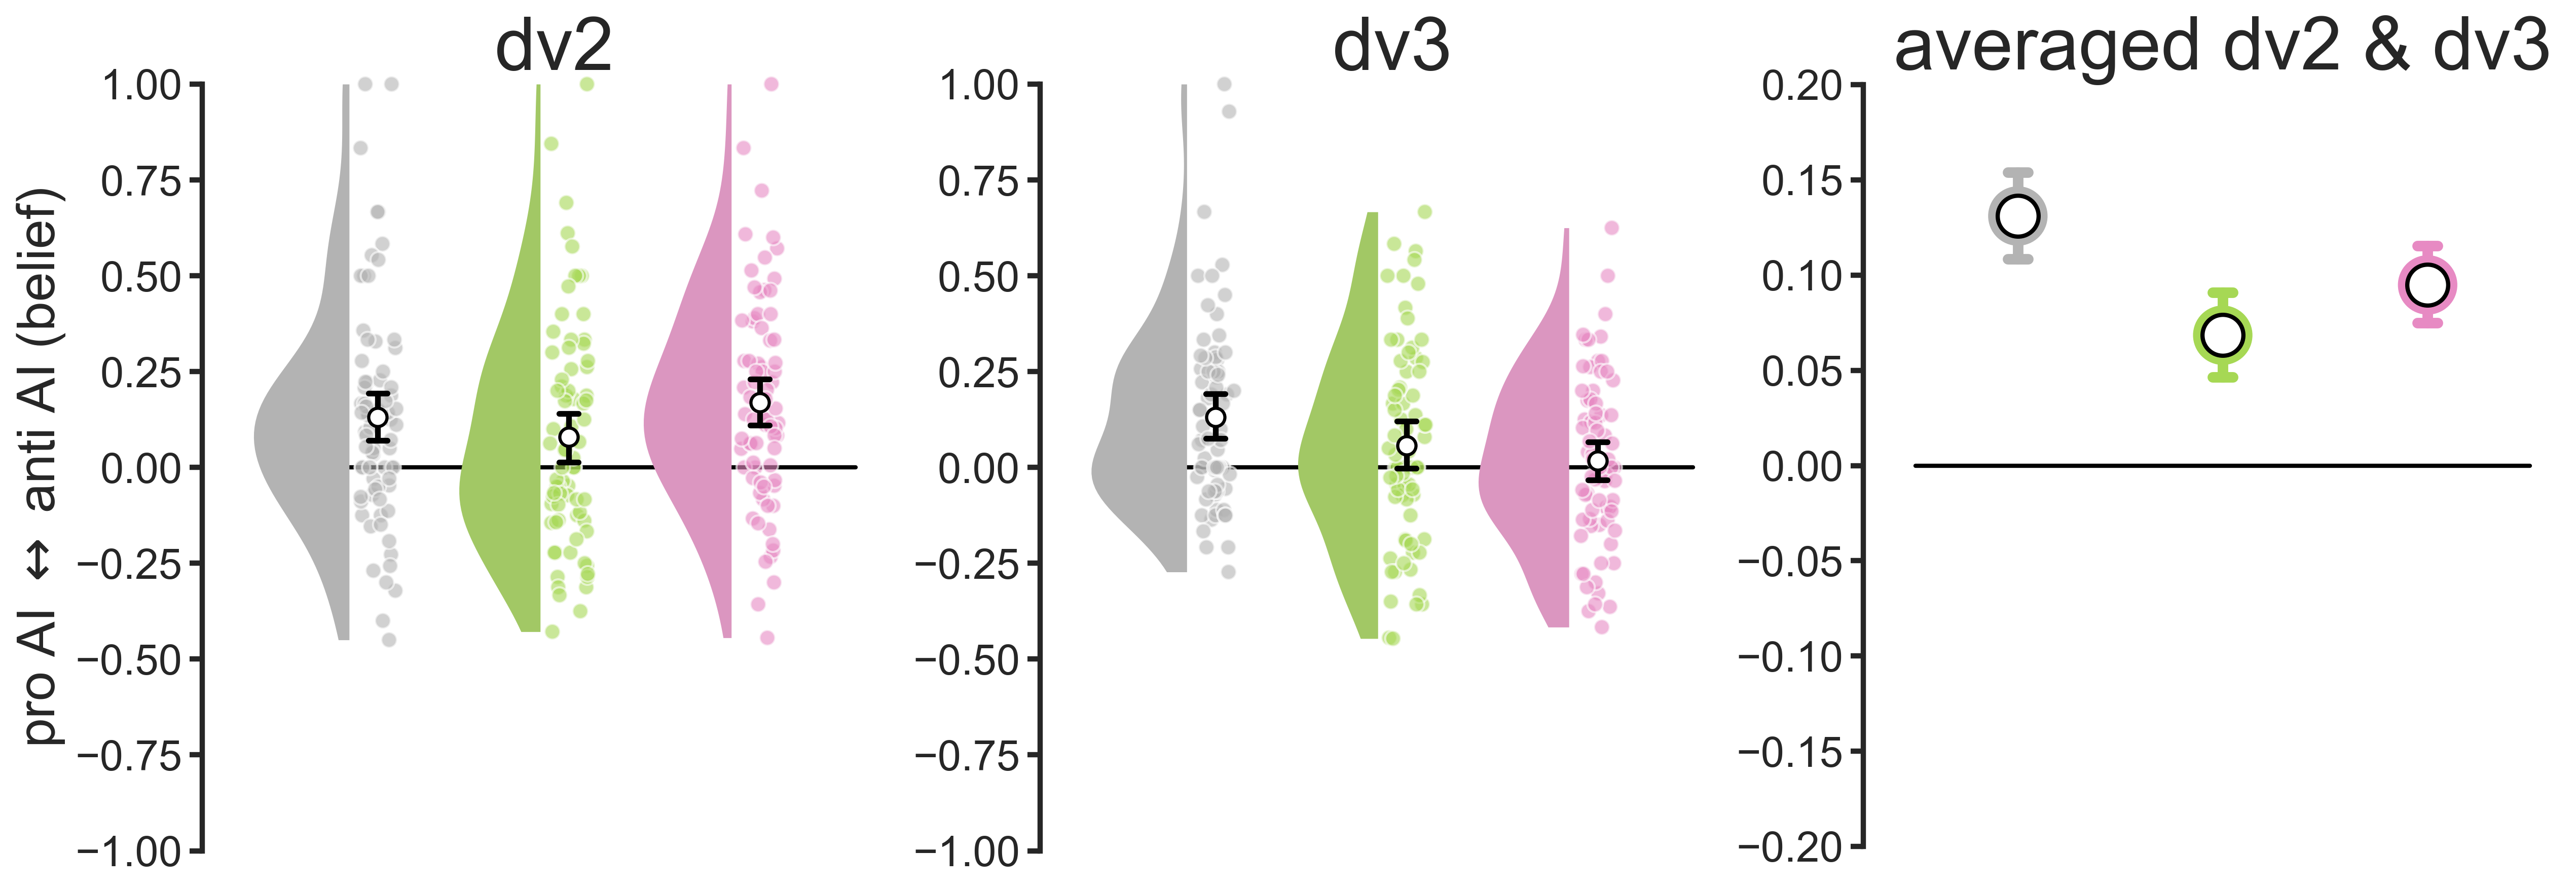

In [7]:
import matplotlib
font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)
# remove warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(
    rc={'figure.figsize':(17.1,6), "figure.dpi": 300, 'legend.fontsize': 20, 'axes.labelsize': 25,
      'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.family': 'sans-serif', 'axes.titlesize': 35,
      'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['axes.linewidth'] = 2.5

m = df.groupby(['engine', 'prolific_id']).correct.mean()
med = m.median() 

ids_below = m[m<med].index
ids_above = m[m>=med].index

# remove warning 

palette = sns.color_palette("Set2")
p = [palette[7], palette[4], palette[3]]

green = '#71c055'
green2 = '#9bca3c'
mauve = '#d1499b'
mauve2 = '#854e9e'
palette = p#[palette[7], green2, mauve2]
sns.set_palette(p)

# avg = df.groupby(['engine', 'prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
order = ('non_moral', 'impersonal_moral', 'personal_moral')
y = 'bias_answer'
count = 0
handles = []

for engine in ('dv2', 'dv3'):
    count += 1
    plt.subplot(1, 3, count)
    print('dataset=', engine)
    df_ = bias[bias.engine==engine].groupby(['prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
    # df_ = df_[df_.prolific_id.isin(ids_below)]
    # plt.plot([0, 2], [0, 0], 'k--', lw=2)
        # df_ = df_[df_.correct > df_.correct.median()]
    # df_ = df_[df_.correct > df_.correct.median()]

    # sns.barplot(x='cond', y=y, data=df_, order=order, zorder=-1)
    ax = raincloud(x='cond', y=y, markersize=7.4,   df=df_, order=order, palette=palette, width=1, bw=.4,)# lw=.5, lw2=.5)
    plt.ylabel(f'pro AI $\leftrightarrow$ anti AI (belief)')
    if count >1:
        plt.ylabel('')

    plt.ylim(-1, 1)
    # plt.ylim(-, .6)
    # hline at 0
    # plt.axhline(0, color='k', ls='--', lw=1, zorder=-1, alpha=.5)
    plt.xlabel('')
    
    # rotate x-axis labels
    plt.xticks(rotation=45, labels=[], ticks=[])

    plt.tick_params(length=0, axis='x')

    # plt.yticks(np.arange(-1., 1.25, .25))
    # change yticks label fontsize
    plt.tick_params(axis='y', which='major', labelsize=20)

    # sns.stripplot(x='cond', y='bias_source', data=df_, edgecolor='w', linewidth=.8, jitter=0.1, size=7, order=order, zorder=1, alpha=.9)
    plt.tight_layout()
    plt.title(engine.replace('_', ' '))
    
    sns.despine(bottom=True, offset=10, trim=True)

    x_lim = plt.gca().get_xlim()
    plt.plot(x_lim, [0, 0], color='black', zorder=0, linewidth=2)



    # get handle for legend
    # h, labels  = ax.get_legend_handles_labels()
    # handles.append(h)
    
  # a legend horizontal line
# plt.legend(title='Condition', loc='upper center', bbox_to_anchor=(-0.7, -0.1), ncol=3, fontsize=20, title_fontsize=20)
# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# sns.barplot(x='cond', y=y, data=df_, order=order, zorder=-1)
plt.subplot(1, 3, 3)
avg_ = bias.groupby(['engine', 'prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
# now average avg_ over engine = dv2, dv3
avg_ = avg_[avg_.engine.isin(['dv2', 'dv3'])].groupby(['prolific_id', 'cond'], as_index=False).mean(numeric_only=True)


# plt.plot([0, 2], [0, 0], 'k--', lw=2, color='gray')
# ax = raincloud(x='engine', y=y, markersize=7.4,   df=avg_, order=('dv2', 'dv3', 'dv2_humanized'), palette=palette, width=1, bw=.3,)# lw=.5, lw2=.5)
sns.pointplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, capsize=0.1, errwidth=5, palette=palette, scale=3.2, join=False)
plt.scatter(x=[0, 1, 2], y=avg_.groupby('cond').bias_answer.mean().reindex(order), color='white', s=150*2.5, edgecolor='black', linewidth=2, zorder=4)

# sns.barplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, errwidth=4, palette=palette)
plt.ylim(-1, 1.)
pos = list(plt.gca().get_position().bounds)
plt.ylim(-.2, 0.2)
# remove xticks
plt.xticks(ticks=[], labels=[])
plt.xlabel('')
plt.ylabel('')
# despine 
plt.tick_params(axis='y', which='major', labelsize=20)
# plt.title ('averaged dv2 & dv3')
plt.tight_layout()
sns.despine(bottom=True, offset=10)
# plt.savefig(
    # '../outputs/figures/fig2.svg', dpi=300, bbox_inches='tight')
# return
# import matplotlib.patches as mpatches
# colors = palette
# handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, ['non-moral', 'impersonal moral', 'personal moral'])]
# plt.legend(loc='lower center', handles=handles, labels=['non-moral', 'impersonal moral', 'personal moral'], ncol=3, bbox_to_anchor=(-.95, -0.1))

# plt.gca().set_position(plt.gca().get_position().bounds[:-1] + [0.5])
pos[-1] = 0.835
pos[1] = 0.06
plt.gca().set_position(pos)

plt.plot(x_lim, [0, 0], color='black', zorder=0, linewidth=2)
plt.title('averaged dv2 & dv3')
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)
# plt.savefig('../outputs/figures/fig2C.svg', dpi=300, bbox_inches='tight')

In [9]:
import pingouin as pg

pg.ttest(bias[(bias.cond.isin(['non_moral', 'personal_moral', 'impersonal_moral'])) & (bias.engine=='dv3')].bias_answer, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.065466,216,two-sided,0.000067,"[0.04, 0.1]",0.275982,197.322,0.981572


dataset= dv2
dataset= dv3


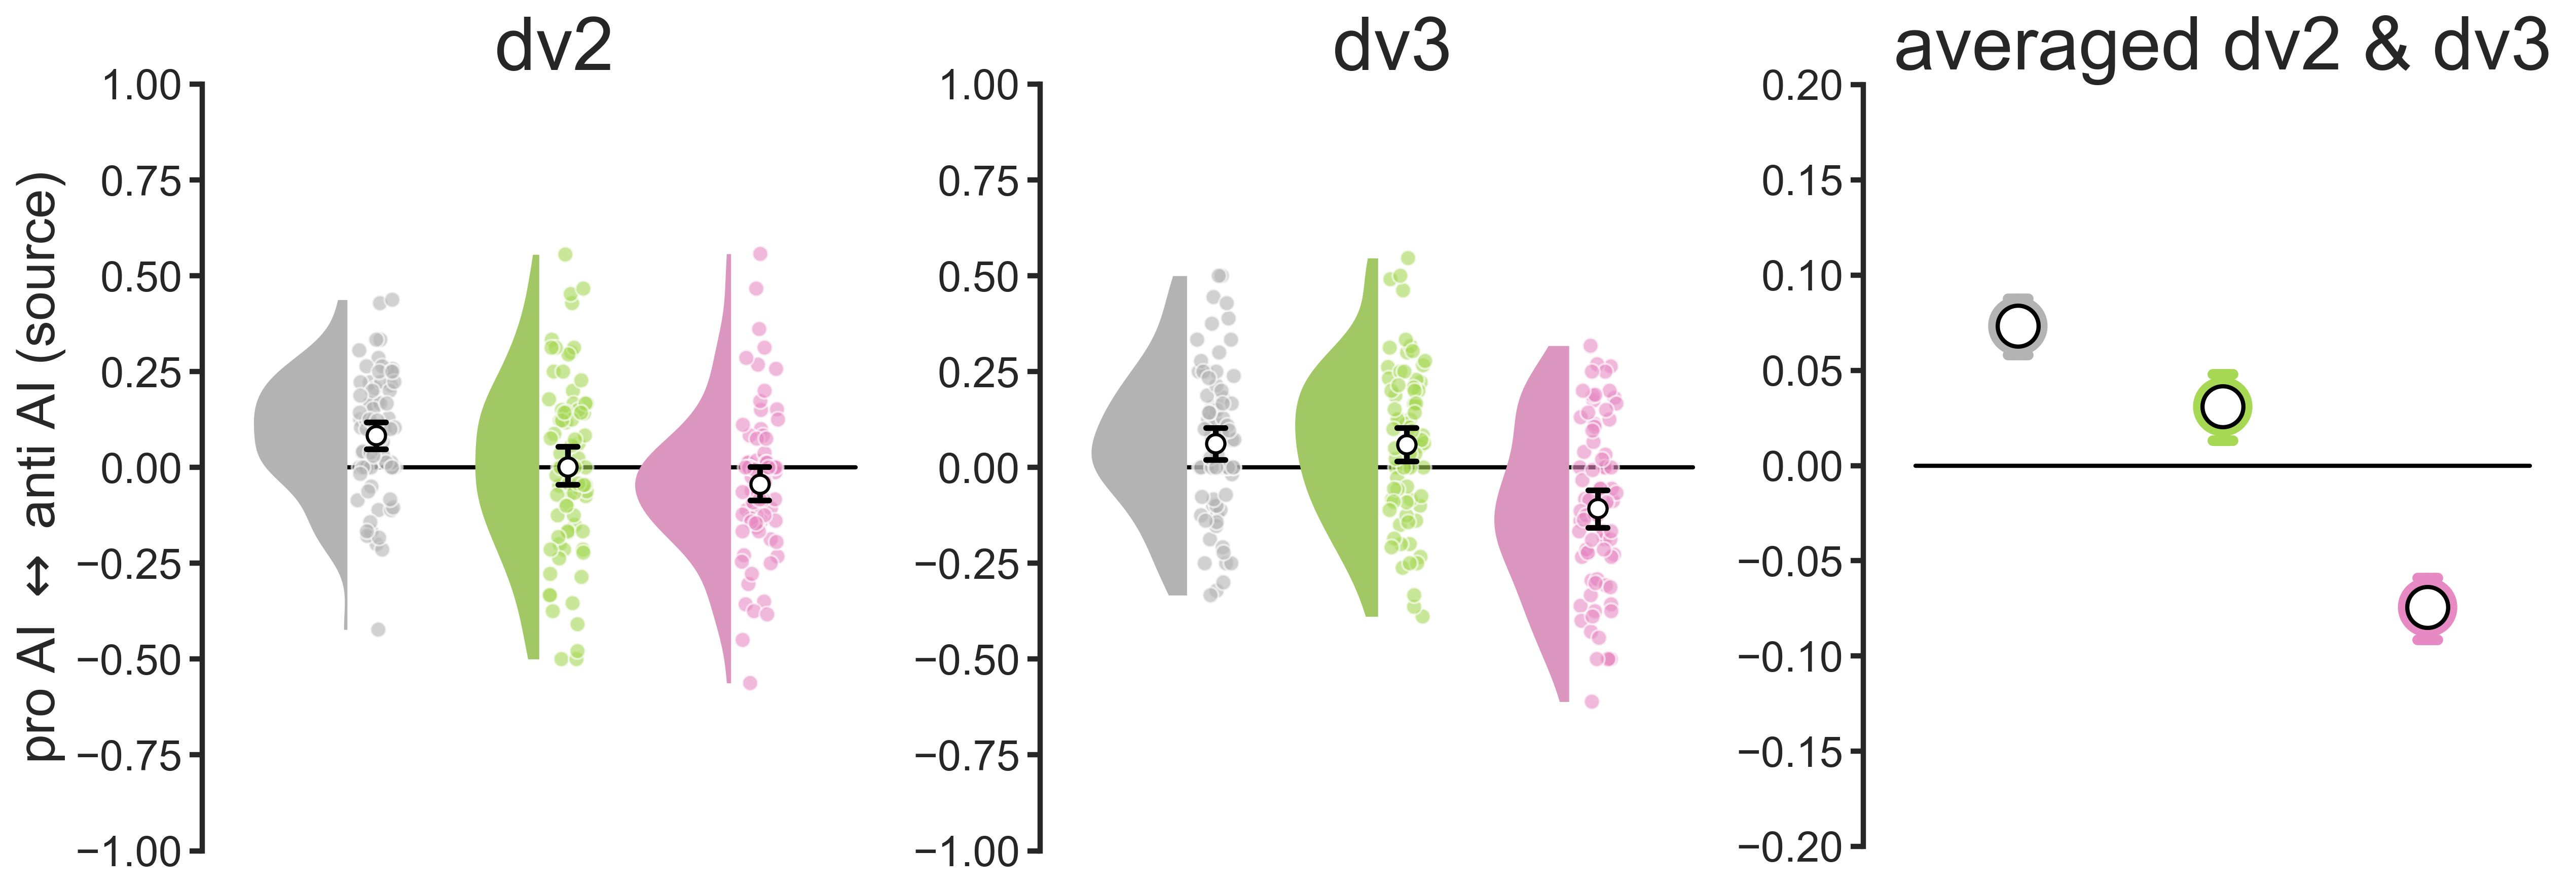

In [8]:
import matplotlib
font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)
# remove warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(
    rc={'figure.figsize':(17.1,6), "figure.dpi": 300, 'legend.fontsize': 20, 'axes.labelsize': 25,
      'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.family': 'sans-serif', 'axes.titlesize': 35,
      'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['axes.linewidth'] = 2.5

m = df.groupby(['engine', 'prolific_id']).correct.mean()
med = m.median() 

ids_below = m[m<med].index
ids_above = m[m>=med].index

# remove warning 

palette = sns.color_palette("Set2")
p = [palette[7], palette[4], palette[3]]

green = '#71c055'
green2 = '#9bca3c'
mauve = '#d1499b'
mauve2 = '#854e9e'
palette = p#[palette[7], green2, mauve2]
sns.set_palette(p)

# avg = df.groupby(['engine', 'prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
order = ('non_moral', 'impersonal_moral', 'personal_moral')
y = 'bias_source'
count = 0
handles = []

for engine in ('dv2', 'dv3'):
    count += 1
    plt.subplot(1, 3, count)
    print('dataset=', engine)
    df_ = bias[bias.engine==engine].groupby(['prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
    # df_ = df_[df_.prolific_id.isin(ids_below)]
    # plt.plot([0, 2], [0, 0], 'k--', lw=2)
        # df_ = df_[df_.correct > df_.correct.median()]
    # df_ = df_[df_.correct > df_.correct.median()]

    # sns.barplot(x='cond', y=y, data=df_, order=order, zorder=-1)
    ax = raincloud(x='cond', y=y, markersize=7.4,   df=df_, order=order, palette=palette, width=1, bw=.4,)# lw=.5, lw2=.5)
    plt.ylabel(f'pro AI $\leftrightarrow$ anti AI (source)')
    if count >1:
        plt.ylabel('')

    plt.ylim(-1, 1)
    # plt.ylim(-, .6)
    # hline at 0
    # plt.axhline(0, color='k', ls='--', lw=1, zorder=-1, alpha=.5)
    plt.xlabel('')
    
    # rotate x-axis labels
    plt.xticks(rotation=45, labels=[], ticks=[])

    plt.tick_params(length=0, axis='x')

    # plt.yticks(np.arange(-1., 1.25, .25))
    # change yticks label fontsize
    plt.tick_params(axis='y', which='major', labelsize=20)

    # sns.stripplot(x='cond', y='bias_source', data=df_, edgecolor='w', linewidth=.8, jitter=0.1, size=7, order=order, zorder=1, alpha=.9)
    plt.tight_layout()
    plt.title(engine.replace('_', ' '))
    
    sns.despine(bottom=True, offset=10, trim=True)

    x_lim = plt.gca().get_xlim()
    plt.plot(x_lim, [0, 0], color='black', zorder=0, linewidth=2)



    # get handle for legend
    # h, labels  = ax.get_legend_handles_labels()
    # handles.append(h)
    
  # a legend horizontal line
# plt.legend(title='Condition', loc='upper center', bbox_to_anchor=(-0.7, -0.1), ncol=3, fontsize=20, title_fontsize=20)
# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# sns.barplot(x='cond', y=y, data=df_, order=order, zorder=-1)
plt.subplot(1, 3, 3)
avg_ = bias.groupby(['engine', 'prolific_id', 'cond'], as_index=False).mean(numeric_only=True)
# now average avg_ over engine = dv2, dv3
avg_ = avg_[avg_.engine.isin(['dv2', 'dv3'])].groupby(['prolific_id', 'cond'], as_index=False).mean(numeric_only=True)


# plt.plot([0, 2], [0, 0], 'k--', lw=2, color='gray')
# ax = raincloud(x='engine', y=y, markersize=7.4,   df=avg_, order=('dv2', 'dv3', 'dv2_humanized'), palette=palette, width=1, bw=.3,)# lw=.5, lw2=.5)
sns.pointplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, capsize=0.1, errwidth=5, palette=palette, scale=3.2, join=False)
plt.scatter(x=[0, 1, 2], y=avg_.groupby('cond').bias_source.mean().reindex(order), color='white', s=150*2.5, edgecolor='black', linewidth=2, zorder=4)

# sns.barplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, errwidth=4, palette=palette)
plt.ylim(-1, 1.)
pos = list(plt.gca().get_position().bounds)
plt.ylim(-.2, 0.2)
# remove xticks
plt.xticks(ticks=[], labels=[])
plt.xlabel('')
plt.ylabel('')
# despine 
plt.tick_params(axis='y', which='major', labelsize=20)
# plt.title ('averaged dv2 & dv3')
plt.tight_layout()
sns.despine(bottom=True, offset=10)
# plt.savefig(
    # '../outputs/figures/fig2.svg', dpi=300, bbox_inches='tight')
# return
# import matplotlib.patches as mpatches
# colors = palette
# handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, ['non-moral', 'impersonal moral', 'personal moral'])]
# plt.legend(loc='lower center', handles=handles, labels=['non-moral', 'impersonal moral', 'personal moral'], ncol=3, bbox_to_anchor=(-.95, -0.1))

# plt.gca().set_position(plt.gca().get_position().bounds[:-1] + [0.5])
pos[-1] = 0.835
pos[1] = 0.06
plt.gca().set_position(pos)

plt.plot(x_lim, [0, 0], color='black', zorder=0, linewidth=2)
plt.title('averaged dv2 & dv3')
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)
# plt.savefig('../outputs/figures/fig2C.svg', dpi=300, bbox_inches='tight')